In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "4"  # Set the GPU 2 to use

In [24]:
import os
import argparse
from PIL import Image
import torch
from diffusers import DDIMScheduler, AutoencoderKL, ControlNetModel, StableDiffusionControlNetPipeline
from insightface.app import FaceAnalysis

import cv2
import gradio as gr
import numpy as np
import torch
from PIL import Image
from diffusers import DDIMScheduler, AutoencoderKL, ControlNetModel, StableDiffusionControlNetPipeline
from insightface.app import FaceAnalysis
from insightface.utils import face_align

from uniportrait import inversion
from uniportrait.uniportrait_attention_processor import attn_args
from uniportrait.uniportrait_pipeline import UniPortraitPipeline

# Configuration
device = "cuda"
torch_dtype = torch.float16

# Model paths
base_model_path = "SG161222/Realistic_Vision_V5.1_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
controlnet_pose_ckpt = "lllyasviel/control_v11p_sd15_openpose"
image_encoder_path = "models/IP-Adapter/models/image_encoder"
ip_ckpt = "models/IP-Adapter/models/ip-adapter_sd15.bin"
face_backbone_ckpt = "models/glint360k_curricular_face_r101_backbone.bin"
uniportrait_faceid_ckpt = "models/uniportrait-faceid_sd15.bin"
uniportrait_router_ckpt = "models/uniportrait-router_sd15.bin"

# Load ControlNet
pose_controlnet = ControlNetModel.from_pretrained(controlnet_pose_ckpt, torch_dtype=torch_dtype)

# Load Stable Diffusion pipeline
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch_dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=[pose_controlnet],
    torch_dtype=torch_dtype,
    scheduler=noise_scheduler,
    vae=vae,
)

# Load UniPortrait pipeline
uniportrait_pipeline = UniPortraitPipeline(pipe, image_encoder_path, ip_ckpt=ip_ckpt,
                                           face_backbone_ckpt=face_backbone_ckpt,
                                           uniportrait_faceid_ckpt=uniportrait_faceid_ckpt,
                                           uniportrait_router_ckpt=uniportrait_router_ckpt,
                                           device=device, torch_dtype=torch_dtype)

# load face detection assets
face_app = FaceAnalysis(providers=['CUDAExecutionProvider'], allowed_modules=["detection"])
face_app.prepare(ctx_id=0, det_size=(640, 640))


def pad_np_bgr_image(np_image, scale=1.25):
    assert scale >= 1.0, "scale should be >= 1.0"
    pad_scale = scale - 1.0
    h, w = np_image.shape[:2]
    top = bottom = int(h * pad_scale)
    left = right = int(w * pad_scale)
    ret = cv2.copyMakeBorder(np_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(128, 128, 128))
    return ret, (left, top)


# Helper function to process multiple images
def process_faces(image_paths):
    """Load and process multiple face images for inference."""
    images = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        images.append(img)
    return images


def process_faceid_image(pil_faceid_image):
    np_faceid_image = np.array(pil_faceid_image.convert("RGB"))
    img = cv2.cvtColor(np_faceid_image, cv2.COLOR_RGB2BGR)
    faces = face_app.get(img)  # bgr
    if len(faces) == 0:
        # padding, try again
        _h, _w = img.shape[:2]
        _img, left_top_coord = pad_np_bgr_image(img)
        faces = face_app.get(_img)
        if len(faces) == 0:
            gr.Info("Warning: No face detected in the image. Continue processing...")

        min_coord = np.array([0, 0])
        max_coord = np.array([_w, _h])
        sub_coord = np.array([left_top_coord[0], left_top_coord[1]])
        for face in faces:
            face.bbox = np.minimum(np.maximum(face.bbox.reshape(-1, 2) - sub_coord, min_coord), max_coord).reshape(4)
            face.kps = face.kps - sub_coord

    faces = sorted(faces, key=lambda x: abs((x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1])), reverse=True)
    faceid_face = faces[0]
    norm_face = face_align.norm_crop(img, landmark=faceid_face.kps, image_size=224)
    pil_faceid_align_image = Image.fromarray(cv2.cvtColor(norm_face, cv2.COLOR_BGR2RGB))

    return pil_faceid_align_image


def prepare_single_faceid_cond_kwargs(pil_faceid_image=None, pil_faceid_supp_images=None,
                                      pil_faceid_mix_images=None, mix_scales=None):
    pil_faceid_align_images = []
    if pil_faceid_image:
        pil_faceid_align_images.append(process_faceid_image(pil_faceid_image))
    if pil_faceid_supp_images and len(pil_faceid_supp_images) > 0:
        for pil_faceid_supp_image in pil_faceid_supp_images:
            if isinstance(pil_faceid_supp_image, Image.Image):
                pil_faceid_align_images.append(process_faceid_image(pil_faceid_supp_image))
            else:
                pil_faceid_align_images.append(
                    process_faceid_image(Image.open(BytesIO(pil_faceid_supp_image)))
                )

    mix_refs = []
    mix_ref_scales = []
    if pil_faceid_mix_images:
        for pil_faceid_mix_image, mix_scale in zip(pil_faceid_mix_images, mix_scales):
            if pil_faceid_mix_image:
                mix_refs.append(process_faceid_image(pil_faceid_mix_image))
                mix_ref_scales.append(mix_scale)

    single_faceid_cond_kwargs = None
    if len(pil_faceid_align_images) > 0:
        single_faceid_cond_kwargs = {
            "refs": pil_faceid_align_images
        }
        if len(mix_refs) > 0:
            single_faceid_cond_kwargs["mix_refs"] = mix_refs
            single_faceid_cond_kwargs["mix_scales"] = mix_ref_scales

    return single_faceid_cond_kwargs


def text_to_multi_id_generation_process(
        pil_faceid_images=None,
        pil_faceid_supp_images=None,
        pil_faceid_mix_images=None,
        mix_scales=None,
        faceid_scale=0.0,
        face_structure_scale=0.0,
        prompt="",
        negative_prompt="",
        num_samples=1,
        seed=-1,
        image_resolution="512x512",
        inference_steps=25,
):
    if seed == -1:
        seed = None

    if pil_faceid_images is None:
        pil_faceid_images = []
    if pil_faceid_supp_images is None:
        pil_faceid_supp_images = []
    if pil_faceid_mix_images is None:
        pil_faceid_mix_images = []
    if mix_scales is None:
        mix_scales = []

    # Ensure input lists align in length
    num_faceids = len(pil_faceid_images)
    pil_faceid_supp_images = pil_faceid_supp_images or [None] * num_faceids
    pil_faceid_mix_images = pil_faceid_mix_images or [[] for _ in range(num_faceids)]
    mix_scales = mix_scales or [[] for _ in range(num_faceids)]

    cond_faceids = []
    for i in range(num_faceids):
        faceid_cond_kwargs = prepare_single_faceid_cond_kwargs(
            pil_faceid_images[i],
            pil_faceid_supp_images[i],
            pil_faceid_mix_images[i],
            mix_scales[i]
        )
        if faceid_cond_kwargs is not None:
            cond_faceids.append(faceid_cond_kwargs)

    # Reset attention arguments
    attn_args.reset()
    attn_args.lora_scale = 1.0 if len(cond_faceids) == 1 else 0.0  # single-faceid lora
    attn_args.multi_id_lora_scale = 1.0 if len(cond_faceids) > 1 else 0.0  # multi-faceid lora
    attn_args.faceid_scale = faceid_scale if len(cond_faceids) > 0 else 0.0
    attn_args.num_faceids = len(cond_faceids)
    print(attn_args)

    # Generate images
    h, w = int(image_resolution.split("x")[0]), int(image_resolution.split("x")[1])
    prompt = [prompt] * num_samples
    negative_prompt = [negative_prompt] * num_samples

    # Added : use controlnet_conditioning_scale
    # Open from assets/test/family.jpeg
    from controlnet_aux import OpenposeDetector
    processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
    # Choose random one image in "assets/4_people"
    pose_image_list = os.listdir('assets/2_people')
    # input_image = Image.open(f'assets/2_people/{pose_image_list[torch.randint(1, len(pose_image_list), (1,)).item()]}')
    input_image = Image.open(f'assets/2_people/{pose_image_list[0]}')

    pose_image = processor(input_image, hand_and_face=True)

    images = uniportrait_pipeline.generate(
        prompt=prompt,
        negative_prompt=negative_prompt,
        cond_faceids=cond_faceids,
        face_structure_scale=face_structure_scale,
        seed=seed,
        guidance_scale=7.5,
        num_inference_steps=inference_steps,
        image=[pose_image],
        controlnet_conditioning_scale=[0.5]
    )

    # Collect final outputs
    final_out = []
    for pil_image in images:
        final_out.append(pil_image)

    for single_faceid_cond_kwargs in cond_faceids:
        final_out.extend(single_faceid_cond_kwargs["refs"])
        if "mix_refs" in single_faceid_cond_kwargs:
            final_out.extend(single_faceid_cond_kwargs["mix_refs"])

    return final_out

from PIL import Image
import io
import os
import torch
from diffusers import DDIMScheduler, AutoencoderKL, ControlNetModel, StableDiffusionControlNetPipeline
from insightface.app import FaceAnalysis
from uniportrait.uniportrait_attention_processor import attn_args
from uniportrait.uniportrait_pipeline import UniPortraitPipeline

import matplotlib.pyplot as plt


def run_pipeline(
        pil_faceid_images=None,
        pil_faceid_supp_images=None,
        pil_faceid_mix_images=None,
        mix_scales=None,
        faceid_scale=0.7,
        face_structure_scale=0.3,
        prompt="",
        negative_prompt="",
        num_samples=1,
        seed=0,
        image_resolution="512x512",
        inference_steps=25,
        output_path='output',
  ):
    # Load images
    pil_faceid_images = process_faces(pil_faceid_images)
    pil_faceid_supp_images = process_faces(pil_faceid_supp_images) if pil_faceid_supp_images is not None else None
    pil_faceid_mix_images = process_faces(pil_faceid_mix_images) if pil_faceid_mix_images is not None else None

    # Inference
    images = text_to_multi_id_generation_process(
            pil_faceid_images=pil_faceid_images,
            pil_faceid_supp_images=pil_faceid_supp_images,
            pil_faceid_mix_images=pil_faceid_mix_images,
            mix_scales=mix_scales,
            faceid_scale=faceid_scale,
            face_structure_scale=face_structure_scale,
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_samples=num_samples,
            seed=seed,
            image_resolution=image_resolution,
            inference_steps=inference_steps,
    )

    # Save outputs
    os.makedirs(output_path, exist_ok=True)
    grid = []
    for i, img in enumerate(images):
        img.save(os.path.join(output_path, f"result_{i}.png"))
        grid.append(img)
    print(f"Inference completed. Results saved in {output_path}")

    ############### 수정된 부분 ################
    from diffusers.utils import make_image_grid # NEW!!
    grid = grid[:num_samples]
    return make_image_grid(grid, rows=1, cols=len(grid))
    ##########################3################


Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


loading from models/IP-Adapter/models/ip-adapter_sd15.bin...
loading from models/uniportrait-faceid_sd15.bin...
loading from models/uniportrait-router_sd15.bin...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /hom

AttentionArgs(
    ip_scale=0.0,
    ip_mask=None,
    lora_scale=0.0,
    multi_id_lora_scale=1.0,
    faceid_scale=0.7,
    num_faceids=2,
    faceid_mask=None,
    enable_share_attn=False,
    adain_queries_and_keys=False,
    shared_score_scale=1.0,
    shared_score_shift=0.0)


100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


Inference completed. Results saved in output


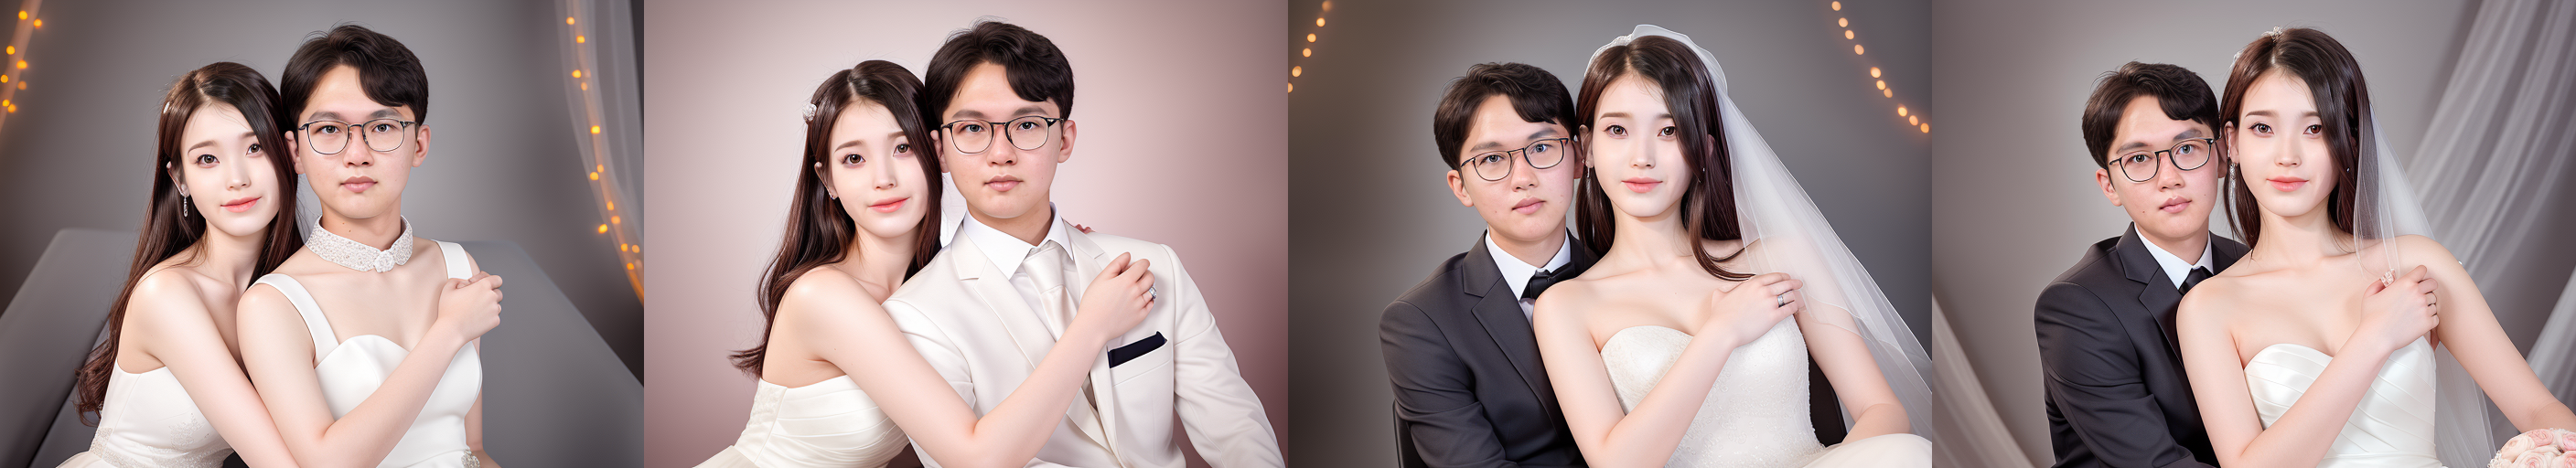

In [25]:
face_ids = ["assets/test/donghwan.JPG", "assets/test/iu.jpg"] #, "assets/test/grandma.png", "assets/test/grandfa.png"]
prompt = "A heartfelt reminder wedding portrait in a professional studio: a couple seated at the center"
run_pipeline(pil_faceid_images=face_ids, prompt=prompt, num_samples=4)